In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
data = pd.read_csv("../data/preprocessed/Event_traces.csv")

In [3]:
success_non_dup_data = data[data["Label"] == "Success"].drop_duplicates(subset=['Features'])
fail_non_dup_data = data[data["Label"] == "Fail"].drop_duplicates(subset=['Features'])

In [4]:
data = pd.merge(success_non_dup_data, fail_non_dup_data, how="outer").reset_index(drop=True)

In [5]:
# # Drop 30% of 'Success' rows to reduce memory consumption
# success_idx = (
#     data.loc[data["Label"] == "Success"]
#         .sample(frac=0.40, random_state=42)
#         .index
# )
# data = data.drop(success_idx).reset_index(drop=True)

In [6]:
# convert string sequence to list sequence
data["Features"] = data["Features"].map(lambda x: x[1:-1].split(","))

# can map timeinterval with the operation ran
data["TimeInterval"] = data["TimeInterval"].map(lambda x: [float(i) for i in x[1:-1].split(",")])

In [7]:
data["Features"]

0        [E5, E22, E5, E5, E26, E26, E26, E11, E9, E11,...
1        [E5, E5, E22, E5, E11, E9, E11, E9, E26, E26, ...
2        [E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,...
3        [E22, E5, E5, E5, E26, E26, E9, E11, E9, E11, ...
4        [E22, E5, E5, E5, E11, E9, E11, E9, E11, E9, E...
                               ...                        
18378    [E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,...
18379    [E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E...
18380    [E22, E5, E5, E5, E26, E26, E26, E11, E9, E9, ...
18381    [E5, E5, E5, E22, E11, E9, E11, E9, E11, E9, E...
18382    [E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,...
Name: Features, Length: 18383, dtype: object

In [8]:
# NOTE: One-Hot Encoding (Temporarily commented out to reduce memory consumption)
# Either we use one-hot encoding or text embedding to represent the log features/text

from sklearn.preprocessing import OneHotEncoder

# unique_features = data["Features"].map(lambda x: [i[1:] for i in x]).explode().unique().astype(np.int32)
# unique_features.sort()

# encoder = OneHotEncoder(sparse_output=False)
# encoded_features = encoder.fit(unique_features.reshape(-1, 1))

# data["Features_Encoded"] = data["Features"].map(lambda x: encoder.transform([[int(i[1:])] for i in x]))

In [9]:
# Text embedding using Sentence-BERT
from sentence_transformers import SentenceTransformer
template_data = pd.read_csv("../data/preprocessed/HDFS.log_templates.csv")

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

embeddings = model.encode(template_data['EventTemplate'].tolist())
template_embedding_dict = {template_id: template_embedding for template_id, template_embedding in zip(template_data["EventId"].tolist(), embeddings)}
data["Features_Embedded"] = data["Features"].map(lambda x: [template_embedding_dict[i] for i in x])

/Users/toanquach/.local/share/virtualenvs/anomaly_detection_project-zdiuRa5q/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# clean data to reduce memory usage
data = data[["Features_Embedded", "TimeInterval", "Label"]]
del model
del embeddings
del template_data

In [11]:
# Maximum length of sequence is chosen as 50 based on the distribution of sequence lengths
# Sequences beyond this length are rare and has drippled effect on buiding even sequences
# (i.e., padding/truncating) for training. Most short or medium sequences from 1 -> 40 in
# length are padded up to 200s if this maximum length is not chosen.

MAX_LEN = 50 # maximum sequence length
EMBED_DIM = 384  # for 'all-MiniLM-L6-v2'

# pad with zeros on the left to create even sequences for training
def left_pad_feature(seq, pad_len=MAX_LEN, embed_dim=EMBED_DIM):
    seq = np.stack(seq)  # shape: (L, 384)
    L = seq.shape[0]
    if L >= pad_len:
        return seq[-pad_len:]  # truncate if too long
    pad = np.zeros((pad_len - L, embed_dim), dtype=seq.dtype)
    return np.vstack([pad, seq])

In [12]:
data["Features_Embedded_Padded"] = data["Features_Embedded"].map(left_pad_feature)

In [13]:
data = data[["Features_Embedded_Padded", "TimeInterval", "Label"]]

In [14]:
data["Features_Embedded_Padded"] = data["Features_Embedded_Padded"].map(lambda x: torch.from_numpy(x))

In [15]:
label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
encoded_labels = label_encoder.fit_transform(data["Label"].values.reshape(-1, 1))

In [16]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [17]:
success_mask = data["Label"] == "Success"
failed_mask = data["Label"] == "Fail"

In [18]:
X_success = torch.stack(data[success_mask]["Features_Embedded_Padded"].tolist())
X_fail = torch.stack(data[failed_mask]["Features_Embedded_Padded"].tolist())

In [19]:
y_success = torch.from_numpy(encoded_labels[success_mask])
y_fail = torch.from_numpy(encoded_labels[failed_mask])

In [20]:
N_success = len(X_success)
train_size = int(0.8 * N_success)
test_size = N_success - train_size

In [21]:
# Create a dataset of only features for training (Unsupervised)
success_dataset = torch.utils.data.TensorDataset(X_success)
train_subset, test_success_subset = random_split(
    success_dataset, [train_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)


In [22]:
# For the Test Loader, we combine the remaining Success data + All Fail data
# We need (X, y) here to evaluate anomaly detection performance
test_success_indices = test_success_subset.indices
X_test_success = X_success[test_success_indices]
y_test_success = y_success[test_success_indices]

X_test = torch.cat([X_test_success, X_fail])
y_test = torch.cat([y_test_success, y_fail])

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
print(f"Training samples (Success only): {len(train_subset)}")
print(f"Test samples (Mixed): {len(test_dataset)}")

Training samples (Success only): 11407
Test samples (Mixed): 6976


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len):
        super(LSTM_VAE, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # --- Encoder ---
        # Input: (batch_size, seq_len, input_dim)
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        # Map final hidden state to latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # --- Decoder ---
        # Map latent vector z back to hidden state dimension
        self.decoder_input = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        # Map LSTM output to original input dimension
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # Pass through LSTM
        _, (h_n, _) = self.encoder_lstm(x)
        # h_n shape: (1, batch_size, hidden_dim) -> squeeze to (batch_size, hidden_dim)
        h = h_n.squeeze(0)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # z: (batch_size, latent_dim)
        h = self.decoder_input(z)  # (batch_size, hidden_dim)
        
        # Repeat the vector to form a sequence for the decoder LSTM
        # Shape becomes: (batch_size, seq_len, hidden_dim)
        h_seq = h.unsqueeze(1).repeat(1, self.seq_len, 1)
        
        out, _ = self.decoder_lstm(h_seq)
        return self.fc_out(out) # (batch_size, seq_len, input_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [25]:
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL Divergence
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kld_loss


In [26]:
def vae_cosine_loss_function(recon_x, x, mu, logvar):
    # Flatten to (batch * seq_len, embed_dim) to compare vectors
    recon_flat = recon_x.reshape(-1, recon_x.size(-1))
    x_flat = x.reshape(-1, x.size(-1))
    
    # Target is 1.0 (perfect alignment)
    target = torch.ones(x_flat.size(0)).to(x.device)
    
    # Cosine Embedding Loss
    # loss is 1 - cos(angle), so 0 means identical direction
    recon_loss = nn.CosineEmbeddingLoss(reduction='sum')(recon_flat, x_flat, target)
    
    # KL Divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kld_loss

In [27]:
def vae_beta_loss_function(recon_x, x, mu, logvar, beta=0.1):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Scale KLD by beta
    return recon_loss + (beta * kld_loss)

In [45]:
# --- Hyperparameters ---
INPUT_DIM = EMBED_DIM
HIDDEN_DIM = 128
LATENT_DIM = 64
SEQ_LEN = MAX_LEN
LEARNING_RATE = 1e-3
EPOCHS = 25

# --- Initialize Model ---
vae = LSTM_VAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, SEQ_LEN)
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)

In [ ]:
print("Starting VAE Training...")
vae.train()
for epoch in range(EPOCHS):
    train_loss = 0
    # Updated unpacking: train_loader now yields single-element tuples (features,)
    for batch_idx, (data_batch,) in enumerate(train_loader):
        optimizer_vae.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = vae(data_batch)
        
        # Loss calculation (Input is Target)
        # loss = vae_loss_function(recon_batch, data_batch, mu, logvar)
        # loss = vae_cosine_loss_function(recon_batch, data_batch, mu, logvar)
        loss = vae_beta_loss_function(recon_batch, data_batch, mu, logvar, beta=0.1)
        loss.backward()
        
        train_loss += loss.item()
        optimizer_vae.step()
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

Starting VAE Training...
Epoch 1, Average Loss: 28.2017
Epoch 2, Average Loss: 18.1011
Epoch 3, Average Loss: 14.2143
Epoch 4, Average Loss: 13.7395
Epoch 5, Average Loss: 13.2073
Epoch 6, Average Loss: 12.5551
Epoch 7, Average Loss: 11.6018
Epoch 8, Average Loss: 9.7621
Epoch 9, Average Loss: 8.8119
Epoch 10, Average Loss: 7.9826
Epoch 11, Average Loss: 7.5376
Epoch 12, Average Loss: 7.2238
Epoch 13, Average Loss: 6.9536
Epoch 14, Average Loss: 6.7298
Epoch 15, Average Loss: 6.6777
Epoch 16, Average Loss: 6.5192
Epoch 17, Average Loss: 6.4947
Epoch 18, Average Loss: 6.5197
Epoch 19, Average Loss: 6.4053
Epoch 20, Average Loss: 6.3341
Epoch 21, Average Loss: 6.2806
Epoch 22, Average Loss: 6.2230
Epoch 23, Average Loss: 6.1993
Epoch 24, Average Loss: 6.1998
Epoch 25, Average Loss: 6.1709


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [48]:
from sklearn.metrics import roc_curve, auc

vae.eval()
reconstruction_errors = []
true_labels = []

print("Evaluating on Test Set...")

with torch.no_grad():
    for data_batch, labels_batch in test_loader:
        # Forward pass
        recon_batch, mu, logvar = vae(data_batch)
        
        # Calculate reconstruction error per sample (MSE)
        # reduction='none' keeps the shape (batch, seq_len, input_dim)
        loss = F.mse_loss(recon_batch, data_batch, reduction='none')
        
        # Sum errors over sequence and feature dimensions to get a single scalar score per sample
        # shape: (batch_size,)
        sample_losses = loss.sum(dim=[1, 2])
        
        reconstruction_errors.extend(sample_losses.cpu().numpy())
        
        # Convert one-hot labels to class indices
        true_labels.extend(labels_batch.argmax(dim=1).cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)
true_labels = np.array(true_labels)

# --- Thresholding Strategy ---
# We assume 'Fail' is the anomaly class.
# We need to map the class indices to names to know which is which.
class_names = label_encoder.categories_[0]
print(f"Class mapping: {dict(enumerate(class_names))}")

fail_idx = np.where(class_names == 'Fail')[0][0]
success_idx = np.where(class_names == 'Success')[0][0]

# Create binary labels for ROC calculation: 1 for Anomaly (Fail), 0 for Normal (Success)
binary_true_labels = (true_labels == fail_idx).astype(int)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(binary_true_labels, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Find Optimal Threshold (Youden's J statistic: max(TPR - FPR))
# This finds the point on the ROC curve closest to the top-left corner
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Optimal Reconstruction Threshold: {optimal_threshold:.4f}")

# --- Generate Predictions ---
# If Error > Threshold -> Predict Anomaly (Fail)
# If Error <= Threshold -> Predict Normal (Success)
binary_preds = (reconstruction_errors > optimal_threshold).astype(int)

# Map binary predictions back to original class indices for the report
all_preds = np.zeros_like(true_labels)
all_preds[binary_preds == 1] = fail_idx
all_preds[binary_preds == 0] = success_idx

all_targets = true_labels

Evaluating on Test Set...
Class mapping: {0: 'Fail', 1: 'Success'}
ROC AUC: 0.8674
Optimal Reconstruction Threshold: 7.0450


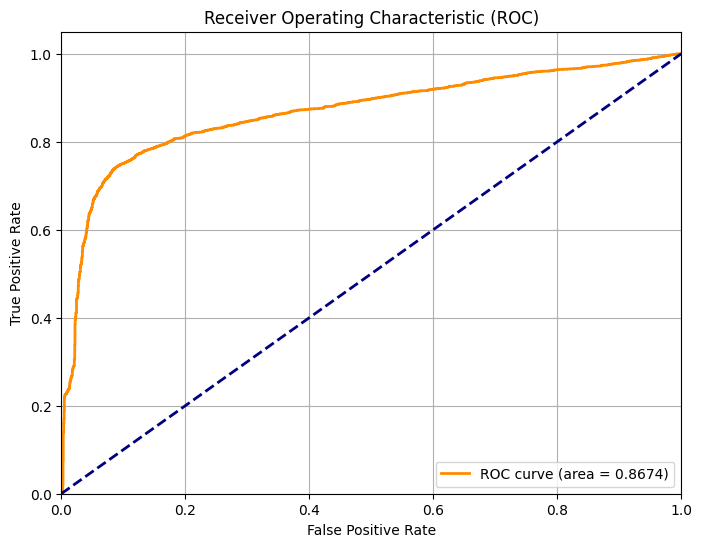

In [49]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [50]:
from sklearn.metrics import classification_report

# Get readable class names from the label encoder
# We need to ensure the order matches the indices (0, 1)
class_names_list = [str(c) for c in label_encoder.categories_[0]]

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names_list, digits=4))

Classification Report:
              precision    recall  f1-score   support

        Fail     0.9218    0.7456    0.8244      4124
     Success     0.7118    0.9085    0.7982      2852

    accuracy                         0.8122      6976
   macro avg     0.8168    0.8271    0.8113      6976
weighted avg     0.8359    0.8122    0.8137      6976



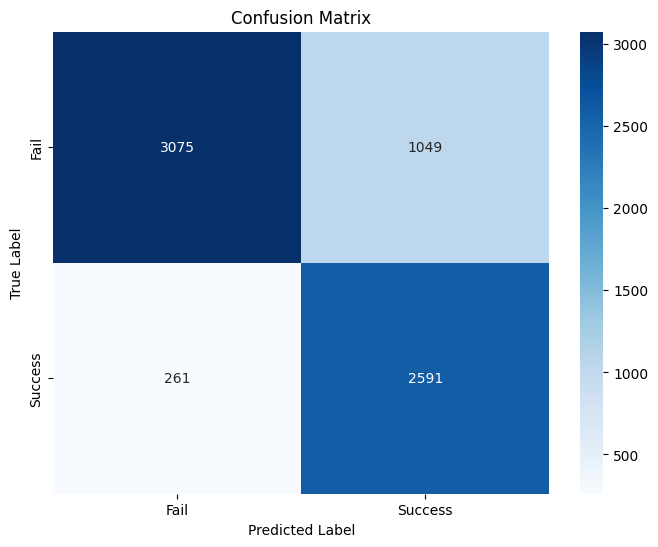

In [51]:
# --- Visual Evaluation: Confusion Matrix ---
cm = confusion_matrix(all_targets, all_preds)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [52]:
from sklearn.metrics import accuracy_score

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(class_names_list):
    print(f"Accuracy for {class_name}: {per_class_accuracy[i]:.4f}")

print("Total Accuracy:", accuracy_score(all_targets, all_preds))

Accuracy for Fail: 0.7456
Accuracy for Success: 0.9085
Total Accuracy: 0.8122133027522935
